In [102]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

In [103]:
np.set_printoptions(precision=2)

In [104]:
import tensorflow as tf

In [105]:
tf.__version__

'2.15.0'

---

Load MNIST Data

---

In [128]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

A generic layer class with forward and backward methods

----

In [129]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

The softmax classifier steps for a batch of comprising $b$ samples represented as the $725\times b$-matrix (724 pixel values plus the bias feature absorbed as its last row) $$\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(0)},\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(b-1)}\end{bmatrix}$$ with one-hot encoded true labels represented as the $10\times b$-matrix (10 possible categories) $$\mathbf{Y}=\begin{bmatrix}\mathbf{y}^{(0)}&\ldots&\mathbf{y}^{(b-1)}\end{bmatrix}$$ using a randomly initialized $10\times725$-weights matrix $\mathbf{W}$:

1. Calculate $10\times b$-raw scores matrix : $$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{z}^{(0)}&\ldots&\mathbf{W}\mathbf{z}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$
2. Calculate $10\times b$-softmax predicted probabilities matrix: $$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$
3. Predicted probability matrix get a new name: $\hat{\mathbf{Y}} = \mathbf{A}.$
4. The crossentropy (CCE) loss for the $i$th sample is $$L_i = \sum_{k=0}^9-y^{(i)}\log\left(\hat{y}^{(i)}_k\right) = -{\mathbf{y}^{(i)}}^\mathrm{T}\log\left(\mathbf{y}^{(i)}\right)$$ which leads to the average crossentropy (CCE) batch loss for the batch as:
$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}.$$
5. The computational graph for the samples in the batch are presented below:

$\hspace{1.5in}\begin{align*}L_0\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(0)} &= \mathbf{a}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$$\qquad\cdots\qquad$$\begin{align*} L_{b-1}\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(b-1)} &= \mathbf{a}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$
6. Calculate the gradient of the average batch loss w.r.t. weights as: $$\begin{align*}\Rightarrow \nabla_\mathbf{W}(L) &= \frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left(\hat{\mathbf{y}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right)\\&=\frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right).\end{align*}$$
10. The full gradient can be written as $\nabla_\mathbf{W}(L)=$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103292&authkey=%21AMoosVj6GqUSvpc&width=660)


---

---

CCE loss and its gradient for the batch samples:

$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}.$$

$$\begin{align*}\begin{bmatrix}\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)&\ldots&\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\end{bmatrix}=\begin{bmatrix}-y_0^{(0)}/\hat{y}_0^{(0)}&\cdots&-y_0^{(0)}/\hat{y}_0^{(b-1)}\\-y_1^{(0)}/\hat{y}_1^{(0)}&\ldots&-y_1^{(b-1)}/\hat{y}_1^{(b-1)}\\-y_2^{(0)}/\hat{y}_2^{(0)}&\cdots&-y_2^{(b-1)}/\hat{y}_2^{(b-1)}\\\vdots\\-y_9^{(0)}/\hat{y}_9^{(0)}&\cdots&-y_9^{(b-1)}/\hat{y}_9^{(b-1)}\end{bmatrix}\end{align*}$$


---

In [130]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

# TensorFlow in-built function for categorical crossentropy loss
#cce = tf.keras.losses.CategoricalCrossentropy()

---

Softmax activation layer class:

**Forward**:
$$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$

**Backward**:
$$\begin{align*}\begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}(L_0)&\ldots&\nabla_{\mathbf{z}^{(b-1)}}(L_{b-1})\end{bmatrix} &= \begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\cdots&\nabla_{\mathbf{z}^{(b-1)}}\left({\mathbf{a}}^{(b-1)}\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}\end{align*}$$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103299&authkey=%21AIPPR63BJ3UybA8&width=928&height=99)


---

In [125]:
'''Z = np.array([[1., 2., 3.], [4., 5., 6.]])
print(Z)
tf.nn.softmax(Z, axis = 0).numpy()'''

'Z = np.array([[1., 2., 3.], [4., 5., 6.]])\nprint(Z)\ntf.nn.softmax(Z, axis = 0).numpy()'

In [131]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.input = input
    self.output = tf.nn.softmax(self.input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.input.shape[0], output_gradient.shape[1]), dtype = np.float64)
    for b in range(softmax_gradient.shape[1]):
      softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-self.output[:, b].reshape(-1,1).T) * self.output[:, b].reshape(-1,1), output_gradient[:, b])
    return(softmax_gradient)
    ## Following is the efficient of calculating the backward gradient
    #T = (np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (1, 2, 0)) * np.atleast_2d(self.output))
    #return(np.einsum('ijk, ik -> jk', T, output_gradient))

---

Dense layer class:

**Forward**:
$$$$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{z}^{(0)}&\ldots&\mathbf{W}\mathbf{z}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$$$

**Backward**:
$$\begin{align*}\nabla_\mathbf{W}(L)&=\frac{1}{b}\left[\nabla_{\mathbf{W}}(\mathbf{z}^{(0)})\times\nabla_{\mathbf{z^{(0)}}}(L) +\cdots+ \nabla_{\mathbf{W}}(\mathbf{z}^{(b-1)})\times\nabla_{\mathbf{z^{(b-1)}}}(L)\right]\\&=\frac{1}{b}\left[\nabla_{\mathbf{z^{(0)}}}(L){\mathbf{x}^{(0)}}^\mathrm{T}+\cdots+\nabla_{\mathbf{z^{(b-1)}}}(L) {\mathbf{x}^{(b-1)}}^\mathrm{T}\right].\end{align*}$$

---

In [134]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.empty((output_size, input_size+1)) # bias trick
        self.weights[:, :-1] = 0.01*np.random.randn(output_size, input_size)
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
 
    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
 
    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        dense_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
 
        for b in range(output_gradient.shape[1]):
          dense_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
 
        dense_gradient = (1/output_gradient.shape[1])*dense_gradient
        #dense_gradient = np.mean(dense_gradient, axis = 1)
        ## Following is the efficient way of calculating the backward gradient
        #dense_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        self.weights = self.weights + learning_rate * (-dense_gradient)
 

---

Function to generate sample indices for batch processing according to batch size

---

In [135]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Example generation of batch indices

---

In [126]:
## Example generation of batch indices
#num_samples = 64
batch_size = 8
batch_indices = generate_batch_indices(num_samples, batch_size)
print(batch_indices)

[array([10285, 42504, 30969, 12281, 13891, 27741, 50802, 41793]), array([ 6830, 16565, 23332, 27462, 48091, 10638, 10346,  1972]), array([18375, 32453, 12770, 24160, 12735, 26008,  5686, 23340]), array([31832, 44322,  8367, 48034,   276, 39265,  3673, 43054]), array([52331, 34937,  3454, 32222, 22724,  3523, 58578, 24318]), array([30164, 35640, 31232, 12542, 57628,  9350, 50719,  7433]), array([ 9443, 39798, 25988, 21364, 21136, 36348, 39152, 50920]), array([42945, 23727, 25754, 35639, 58428,  4732, 16690, 40904]), array([42341, 51920, 13027, 14930, 41697, 54910,  6558,  8175]), array([37409, 37089, 23729, 30368,  5396, 10690, 23351, 23041]), array([44283, 19437, 21448, 41331, 28033, 18107, 15428, 47210]), array([21390, 53953, 33575,  2205, 22525, 33376, 51777, 17967]), array([ 4542, 10358, 21456, 35850, 20911, 29361, 54807,  4382]), array([23574, 59000, 35858, 14954,  5029, 10718, 22025, 54390]), array([38158, 36722, 51733, 35599, 24980, 31803, 46128, 31426]), array([32301, 49985, 195

---

Train the 0-layer neural network using batch training with batch size = 16

---

In [136]:
## Train the 0-layer neural network using batch training with batch size = 16
learning_rate = 0.01 # learning rate
batch_size = 200 # batch size
nepochs = 20 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float32) # create empty array to store losses over each epoch

# Neural network architecture
dlayer = Dense(num_features, num_labels) # define dense layer
softmax = Softmax() # define softmax activation layer

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    dlayer.forward(X_train[:,batch_indices[b]]) # forward prop
    softmax.forward(dlayer.output) # Softmax activate
    loss += cce(Y_train[:,batch_indices[b]], softmax.output) # calculate loss
    # Backward prop starts here
    grad = cce_gradient(Y_train[:,batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer.backward(grad, learning_rate)
  loss_epoch[epoch] = loss/len(batch_indices)
  print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
  epoch = epoch + 1


Epoch 1: loss = 1.442094
Epoch 2: loss = 0.848225
Epoch 3: loss = 0.682523
Epoch 4: loss = 0.601897
Epoch 5: loss = 0.552775
Epoch 6: loss = 0.519117
Epoch 7: loss = 0.494298
Epoch 8: loss = 0.475101
Epoch 9: loss = 0.459624
Epoch 10: loss = 0.446861
Epoch 11: loss = 0.436090
Epoch 12: loss = 0.426816
Epoch 13: loss = 0.418748
Epoch 14: loss = 0.411703
Epoch 15: loss = 0.405375
Epoch 16: loss = 0.399703
Epoch 17: loss = 0.394559
Epoch 18: loss = 0.389918
Epoch 19: loss = 0.385667
Epoch 20: loss = 0.381741


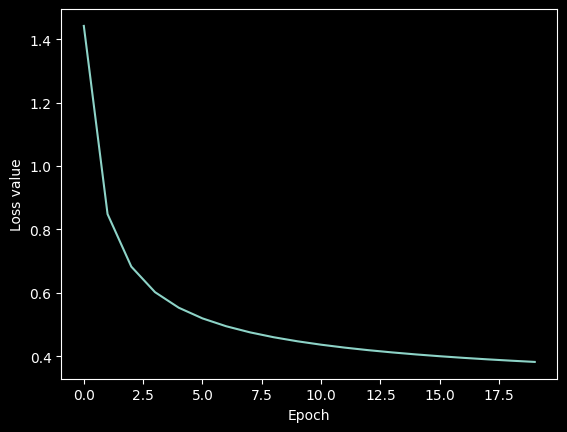

In [137]:
## Plot training loss as a function of epoch:
plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [140]:
## Accuracy on test set
dlayer.forward(X_test)
softmax.forward(dlayer.output)
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


0.9037

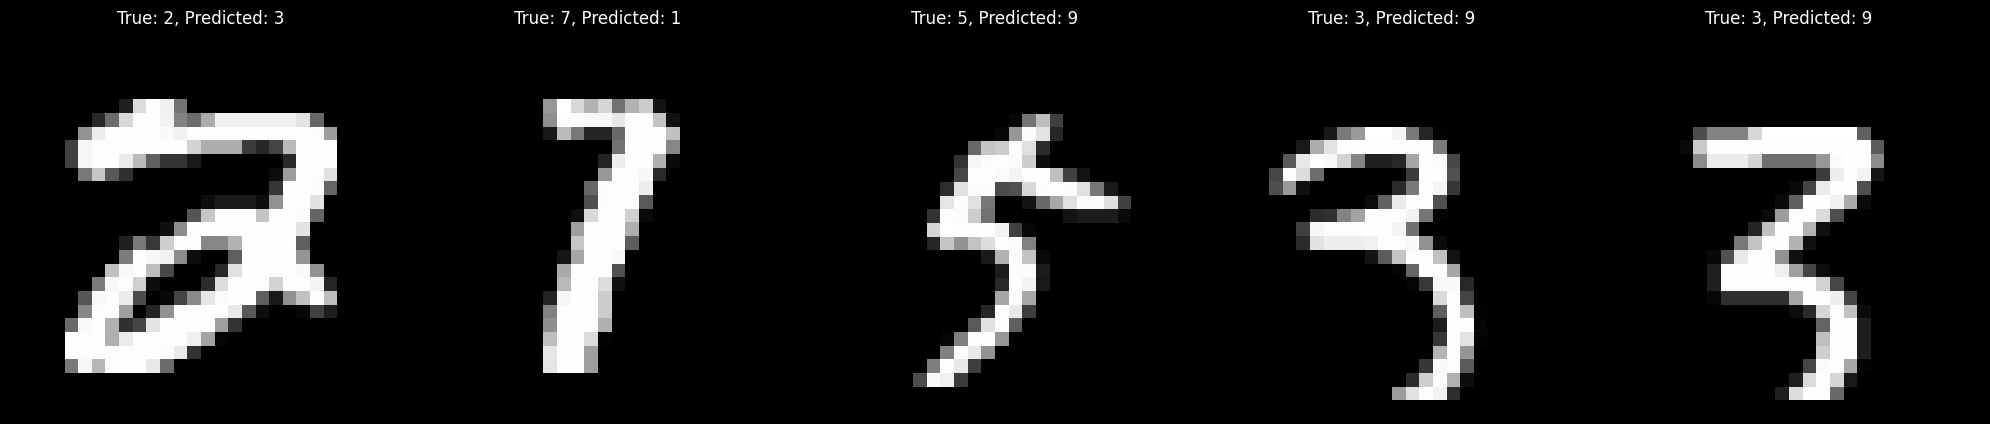

In [146]:
def plot_misclassified_images(X_test, ytrue, ypred, num_images=5):
    misclassified_indices = np.where(ytrue != ypred)[0]
    random_misclassified_indices = np.random.choice(misclassified_indices, num_images, replace=False)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, index in enumerate(random_misclassified_indices):
        axes[i].imshow(X_test[:, index].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"True: {ytrue[index]}, Predicted: {ypred[index]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified_images(X_test, ytrue, ypred)